# The Utilities Module

The `utilities` module of the `ah` package holds functions commonly called by other modules in order for the entire package to run smoothly.
`utilities` includes the following functions:
- __create_sdm__: Creates a self-dissimilarity matrix; this matrix is found by creating audio shingles from feature vectors, and finding the cosine distance between shingles.

- __find_initial_repeats__: Finds all diagonals present in *thresh\_mat*, removing each diagonal as it is found.

- __stretch_diags__: Fills out diagonals in binary self dissimilarity matrix from diagonal starts and lengths.

- __add_annotations__: Adds annotations to each pair of repeated structures according to their length and order of occurence. 

- **\_\_find_song_pattern** : Stitches information about repeat locations from _thresh\_diags_ matrix into a single row. 

- __reconstruct_full_block__: Creates a record of when pairs of repeated structures occur, from the first beat in the song to the last beat of the song. Pairs of repeated structures are marked with 1's.

- **get_annotation_list**: Gets one annotation marker vector, given vector of lengths *key\_lst*.

- **get_yLabels**: Generates the labels for a visualization with *width\_vec* and *anno\_vec*.

- __reformat__ : Transforms a binary matrix representation of when repeats occur in a song into a list of repeated structures detailing the length and occurence of each repeat. 
    
These functions are called multiple times throughout the package to reformat the outputs of various functions. Functions from `utilities` are shown in yellow in the example function pipeline below.
![alt text](pictures/function_pipeline.png)

### Importing necessary modules

In [1]:
# numpy is used for mathematical calculations
import numpy as np

# Set the path for the import
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\aligned-hierarchies")

# Import utilities
from utilities import *
from utilities import __find_song_pattern
import matplotlib.pyplot as plt

## create_sdm

This function creates a self-dissimilarity matrix. This matrix is found by creating audio shingles from feature vectors, and finding the cosine distance between shingles.

The inputs for the function are:
- __fv_mat__ (np.ndarray): A matrix of feature vectors where each column is a timestep and each row includes feature information i.e. an array of 144 columns/beats and 12 rows corresponding to chroma values.
- __num_fv_per_shingle__ (int): The number of feature vectors per audio shingle.

The output for the function is:
- __self_dissim_mat__ (np.ndarray): A self dissimilarity matrix with paired cosine distances between shingles.

In [2]:
fv_mat = np.array([[0, 0.5, 0, 0, 0, 1, 0, 0],
                   [0,   2, 0, 0, 0, 0, 0, 0],
                   [0,   0, 0, 0, 0, 0, 3, 0],
                   [0,   3, 0, 0, 2, 0, 0, 0],
                   [0, 1.5, 0, 0, 5, 0, 0, 0]])

num_fv_per_shingle = 3

print('The input matrix of feature vectors is:\n', fv_mat)
print('The number of feature vectors per audio shingles is:', num_fv_per_shingle)

The input matrix of feature vectors is:
 [[0.  0.5 0.  0.  0.  1.  0.  0. ]
 [0.  2.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  3.  0. ]
 [0.  3.  0.  0.  2.  0.  0.  0. ]
 [0.  1.5 0.  0.  5.  0.  0.  0. ]]
The number of feature vectors per audio shingles is: 3


In [3]:
self_dissim_mat  = create_sdm(fv_mat, num_fv_per_shingle)
print('The resulting self-dissimilarity matrix is:\n', self_dissim_mat)

The resulting self-dissimilarity matrix is:
 [[0.         1.         1.         0.37395249 0.9796637  1.        ]
 [1.         0.         1.         1.         0.45092001 0.95983903]
 [1.         1.         0.         1.         1.         1.        ]
 [0.37395249 1.         1.         0.         1.         1.        ]
 [0.9796637  0.45092001 1.         1.         0.         1.        ]
 [1.         0.95983903 1.         1.         1.         0.        ]]


The resulting self-dissimilarity can be shown as a picture in which the color represents the similarity between two shingles. The darker the color of a pixel, the more similar the two shingles are.  

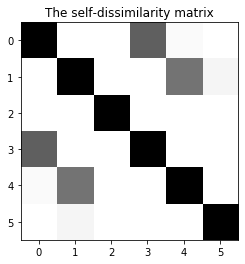

In [4]:
plt.imshow(self_dissim_mat,cmap='gray')
plt.title("The self-dissimilarity matrix")
plt.show()

## find_initial_repeats

This function identifies all repeated structures in a sequential data stream which are represented as diagonals in *thresh\_mat* and then stores the pairs of repeats that correspond to each repeated structure in a list. The function finds the diagonals of lengths from the largest to the smallest, searches for non-overlapping shingles first, and cuts the overlapping shingles to up to 3 non-overlapping parts. As each diagonal is found, they are removed to avoid identifying repeated sub-structures. 

The image below illutrates the overlapping parts given two repeats starting with time steps $i$ and $j$ and having length $k$. The left and right segments will always exist because $i \neq j$, but the middle segment will only exist if $k > 2(j - i)$.

![alt text](pictures/find_initial_repeats.png)

The inputs for the function are:
- __thresh_mat__ (np.ndarray): A thresholded matrix from which diagonals are extracted.
- __bandwidth_vec__ (np.ndarray): A vector of lengths of diagonals to be found.
- __thresh_bw__ (int): The smallest allowed diagonal length.

The output for the function is:
- __all_lst__ (np.ndarray): Pairs of repeats that correspond to diagonals in *thresh\_mat*.

In [5]:
thresh_mat = np.array([[1, 0, 0, 1, 0, 0, 0, 1, 0, 0],
                       [0, 1, 0, 0, 1, 1, 0, 0, 1, 0],
                       [0, 0, 1, 0, 0, 1, 1, 0, 0, 1],
                       [1, 0, 0, 1, 0, 0, 1, 1, 0, 0],
                       [0, 1, 0, 0, 1, 0, 1, 0, 0, 0],
                       [0, 1, 1, 0, 0, 1, 0, 1, 1, 0],
                       [0, 0, 1, 1, 1, 0, 1, 0, 1, 0],
                       [1, 0, 0, 1, 0, 1, 0, 1, 0, 1],
                       [0, 1, 0, 0, 0, 1, 1, 0, 1, 0],
                       [0, 0, 1, 0, 0, 0, 0, 1, 0, 1]])

bandwidth_vec = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
thresh_bw = 0

print('The thresholded matrix is:\n', thresh_mat)
print('The lengths of diagonals to be found are:', bandwidth_vec)
print('The smalled allowed diagonal length is:', thresh_bw)

The thresholded matrix is:
 [[1 0 0 1 0 0 0 1 0 0]
 [0 1 0 0 1 1 0 0 1 0]
 [0 0 1 0 0 1 1 0 0 1]
 [1 0 0 1 0 0 1 1 0 0]
 [0 1 0 0 1 0 1 0 0 0]
 [0 1 1 0 0 1 0 1 1 0]
 [0 0 1 1 1 0 1 0 1 0]
 [1 0 0 1 0 1 0 1 0 1]
 [0 1 0 0 0 1 1 0 1 0]
 [0 0 1 0 0 0 0 1 0 1]]
The lengths of diagonals to be found are: [ 1  2  3  4  5  6  7  8  9 10]
The smalled allowed diagonal length is: 0


In [6]:
all_lst = find_initial_repeats(thresh_mat, bandwidth_vec, thresh_bw)

print("The pairs of repeats are:\n", all_lst)

The pairs of repeats are:
 [[ 6  6  9  9  1]
 [ 5  6  7  8  2]
 [ 7  8  9 10  2]
 [ 1  3  4  6  3]
 [ 1  3  8 10  3]
 [ 2  4  5  7  3]
 [ 2  4  6  8  3]
 [ 1 10  1 10 10]]


## stretch_diags

This function creates binary matrix with full length diagonals from binary matrix of diagonal starts and length of diagonals.
        
The inputs for the function are:
- __thresh_diags__ (np.ndarray): A binary matrix where entries equal to 1 signal the existence of a diagonal.
- __band_width__ (int): The length of encoded diagonals.

The output for the function is:
- __stretch_diag_mat__ (np.ndarray): A logical matrix with diagonals of length _band\_width_ starting at each entry prescribed in *thresh\_diag*.

In [7]:
thresh_diags = np.matrix([[0, 0, 1, 0, 0],
                          [0, 1, 0, 0, 0],
                          [0, 0, 1, 0, 0],
                          [0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0]])

band_width = 3

print("The input matrix is:\n", thresh_diags)
print("The length of the encoded diagonals is:", band_width)

The input matrix is:
 [[0 0 1 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
The length of the encoded diagonals is: 3


In [8]:
stretched_diagonal = stretch_diags(thresh_diags, band_width)

print("The output matrix is:\n", stretched_diagonal)

The output matrix is:
 [[False False False False False False False]
 [False  True False False False False False]
 [ True False  True False False False False]
 [False  True False  True False False False]
 [False False  True False  True False False]
 [False False False False False False False]
 [False False False False False False False]]


## add_annotations

This function adds annotations to each pair of repeated structures according to their length and order of occurence to differentiate between different repeats of the same length. `add_annotations` is called after a function, such as [`find_complete_list`](../ah/blob/master/vignettes/search_vignette.ipynb) creates a matrix representation of pairs of repeats, *input\_mat*. Once the list of pairs of repeats is generated, `add_annotations` first creates a binary matrix that denotes each repeat. `__find_song_pattern` uses this information to create a single row in which entries represent a time step and the repeat group that time step is a member of. Then, annotation markers are added to pairs of repeats by looping over all possible repeat lengths in ascending order. For each repeat length, the annotations are added in another loop, checking whether each repeat already has an anotation assigned. 

The inputs for the function are:
- __input_mat__ (np.ndarray): Pairs of repeats. The first two columns refer to the first repeat of the pair. The third and fourth columns refer to the second repeat of the pair. The fifth column refers to the repeat lengths. The sixth column contains any previous annotations, which will be removed.
- __song_length__ (int): The number of shingles in the song.

The output for the function is:
- __anno_list__ (np.ndarray): Pairs of repeats with annotations marked. 

In [9]:
input_mat = np.array([[2,  5,  8, 11, 4, 0],
                      [7, 10, 14, 17, 4, 0],
                      [2,  5, 15, 18, 4, 0],
                      [8, 11, 15, 18, 4, 0],
                      [9, 12, 16, 19, 4, 0]])

song_length = 19

print("The input array is: \n", input_mat)
print("The number of shingles is:", song_length)

The input array is: 
 [[ 2  5  8 11  4  0]
 [ 7 10 14 17  4  0]
 [ 2  5 15 18  4  0]
 [ 8 11 15 18  4  0]
 [ 9 12 16 19  4  0]]
The number of shingles is: 19


In [10]:
annotated_array = add_annotations(input_mat, song_length)
print("The array of repeats with annotations is:\n", annotated_array)

The array of repeats with annotations is:
 [[ 2  5  8 11  4  1]
 [ 2  5 15 18  4  1]
 [ 8 11 15 18  4  1]
 [ 7 10 14 17  4  2]
 [ 9 12 16 19  4  3]]


## \_\_find_song_pattern

This function decodes *thresh\_diags* which contains the locations or beats of when repeats begin to create a single row in which entries represent a time step and the repeat group that time step is a member of.

The input of this functions is: 

- **thresh\_diags** (np.ndarray): Binary matrix with 1's at the start of each repeat pair and 0's elsewhere

The output for this function is: 

- **song\_pattern** (np.ndarray): Rows where each entry represents a time step and the group that the time step is a member of

In [11]:
thresh_diags = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                         [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                         [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

print("The input matrix is:\n", thresh_diags)

The input matrix is:
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [12]:
song_pattern = __find_song_pattern(thresh_diags)

print("The song pattern is:\n", song_pattern)

The song pattern is:
 [0 1 0 0 0 0 2 1 3 0 0 0 0 2 1 3 0 0 0]


## reconstruct_full_block

This function creates a record of when pairs of repeated structures occur, from the first beat in the song to the end. This record is a binary matrix with a block of 1's for each repeat encoded in *pattern\_mat* whose length is encoded in *pattern\_key*. By looping over all rows of *pattern\_mat*, `reconstruct_full_block` reconstructs each row using the *pattern\_key*. 

For each row of *pattern\_mat*, a new row is created for *pattern\_block* by looping over the same row of *pattern\_mat* and shifting the position of 1's the number of times equivalent to the length of the repeat, storing each unique row with shifted values in a separate array. The sum of all of the shifted rows is then taken along the x-axis, thus creating a row that represents where each repeat occurs with blocks of 1's.

For example, if the row in *pattern\_mat* is [0 0 1 0 0 0 0 0 1 0 0 0 1 0 0], with a repeat length of 3, then new rows created by the for loop are:
<br><br>
<center>[0 0 1 0 0 0 0 0 1 0 0 0 1 0 0]<br>
[0 0 0 1 0 0 0 0 0 1 0 0 0 1 0]<br>
[0 0 0 0 1 0 0 0 0 0 1 0 0 0 1]<br></center><br> 

These rows are then summed along the y-axis to become: [0 0 1 1 1 0 0 0 1 1 1 0 1 1 1] This is then appended to the output *pattern\_block*. 

The inputs for the function are:
- __pattern_mat__ (np.ndarray): A binary matrix with 1's where repeats begin and 0's otherwise
- __pattern_key__ (np.ndarray): The number of feature vectors per audio shingle

The output for the function is:
- __pattern_block__ (np.ndarray): A binary matrix representation for *pattern\_mat* with blocks of 1's equal to the length's prescribed in *pattern\_key*

In [13]:
pattern_mat  = np.array([[0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
                         [0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
                         [0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
                         [1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                         [1, 0, 0, 0, 0, 0, 1, 0, 0, 0]])

pattern_key  = np.array([1, 2, 2, 3, 4])

print("The input binary matrix is:\n", pattern_mat)
print("The input pattern key is:\n", pattern_key)

The input binary matrix is:
 [[0 0 0 0 1 0 0 0 0 1]
 [0 1 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 1 0 0 0]]
The input pattern key is:
 [1 2 2 3 4]


In [14]:
pattern_block  = reconstruct_full_block(pattern_mat, pattern_key)
print("The reconstructed full block is:\n", pattern_block)

The reconstructed full block is:
 [[0 0 0 0 1 0 0 0 0 1]
 [0 1 1 0 0 0 0 1 1 0]
 [0 0 1 1 0 0 0 0 1 1]
 [1 1 1 0 0 0 1 1 1 0]
 [1 1 1 1 0 0 1 1 1 1]]


## reformat

This function is helpful when writing example inputs for aligned hiearchies. It first finds the starting indices of the repeated structures row by row, and assigns the time steps of the repeated structures based on starting indices.
        
The inputs for the function are:
- __pattern_mat__ (np.ndarray): Binary array with 1's where repeats start and 0's otherwise 
- __pattern_key__ (np.ndarray): Array with the lengths of each repeated structure in *pattern\_mat*

The output for the function is:
- __info_mat__ (np.ndarray): Array with the time steps of when the pairs of repeated structures start and end organized

In [15]:
pattern_mat = np.array([[0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
                        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
                        [0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
                        [1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                        [1, 0, 0, 0, 0, 0, 1, 0, 0, 0]])

pattern_key = np.array([1, 2, 2, 3, 4])

print("The input matrix is:\n", pattern_mat)
print("The length of repeated structure is:", pattern_key)

The input matrix is:
 [[0 0 0 0 1 0 0 0 0 1]
 [0 1 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 1 0 0 0]]
The length of repeated structure is: [1 2 2 3 4]


In [16]:
output = reformat(pattern_mat, pattern_key)

print("The output matrix is:\n", output)

The output matrix is:
 [[ 5  5 10 10  1]
 [ 2  3  8  9  2]
 [ 3  4  9 10  2]
 [ 1  3  7  9  3]
 [ 1  4  7 10  4]]


## get_annotation_list

This function takes in vector of lengths *key\_lst*, counts the time each length occurs as its annotation maker, and outputs all annotation markers as a vector.
    
The input for the function is:
- **key_lst** (np.ndarray): Array of lengths in ascending order

The output for the function is:
- **anno_lst_out** (np.ndarray): Array of one possible set of annotation markers for *key\_lst*

In [17]:
key_lst = np.array([1, 2, 2, 3, 3, 3, 5, 7, 8, 8, 9])

print("The input array of lengths is: \n", key_lst)

The input array of lengths is: 
 [1 2 2 3 3 3 5 7 8 8 9]


In [18]:
output = get_annotation_lst(key_lst)

print("The output array is: \n", output)

The output array is: 
 [1 1 2 1 2 3 1 1 1 2 1]


## get_yLabels
This function generates labels for a visualization with repeat lengths and annotations of each length.

The inputs for the function are:

- **width_vec** (np.ndarray): Vector of widths for a visualization
- **anno_vec** (np.ndarray): Array of annotations for a visualization

The output for the function is:
- **ylabels**(str): Labels for the y-axis of a visualization

In [19]:
width_vec = np.array([[1], [2], [3], [4], [4], [5], [5], [6]])
anno_vec = np.array([1, 1, 1, 1, 2, 1, 1, 1])

print("The vector of widths is: \n", width_vec)
print("The array of annotation makers is: \n", anno_vec)

The vector of widths is: 
 [[1]
 [2]
 [3]
 [4]
 [4]
 [5]
 [5]
 [6]]
The array of annotation makers is: 
 [1 1 1 1 2 1 1 1]


In [20]:
output = get_yLabels(width_vec, anno_vec)

print("The output string is: \n", output)

The output string is: 
 ['0' 'w = 1, a = 1' 'w = 2, a = 1' 'w = 3, a = 1' 'w = 4, a = 1'
 'w = 4, a = 2' 'w = 5, a = 1' 'w = 5, a = 1' 'w = 6, a = 1']
